**Group 5 - LAB 4**

Members:
* Daniel Carillo
* Sonia Asto
* Elizabeth Linares

# 1. Double Lasso - Testing the Convergence Hypothesis

# 2. Double Lasso - Testing the Convergence Hypothesis

## 2.1  Explain what is the Double Lasso Approach


Urminsky, Hansen and Chernozhukov introduce double-lasso regression as a primary method of variable selection because using lasso regression directly can be problematic. Coefficients estimated by the lasso that are actually nonzero are often underestimated, and the lasso may mistakenly exclude variables with nonzero coefficients, especially variables with moderate effects. Each of these phenomena usually causes significant regularization bias that negatively affects estimation and inference about $\beta_1$. The omission of covariates with moderate but nonzero coefficients is especially problematic and results in omitted variable bias when these covariates are relevant predictors of the focal variable.To overcome these biases, it is recommended to use the "double-lasso" variable selection procedure that was explicitly designed to alleviate both sources of bias, as follows:

* Step 1: Fit a lasso regression predicting the dependent variable, and keeping track of the variables with non-zero estimated coefficients: $Y_i=\alpha_0 + \alpha_1 W_{i1} + \alpha_2 W_{i2} + ... + \alpha_k W_{ik} + \epsilon_i$

* Step 2: Fit a lasso regression predicting the focal independent variable, keeping track of the variables with non-zero estimated coefficients: $X_i=\delta_0 + \delta_1 W_{i1} + \delta_2 W_{i2} + ... + \delta_k W_{ik} + \epsilon_i$

If $X_i$ is an effectively randomized treatment, no covariates should be selected in this step.

* Step 3: Fit a linear regression of the dependent variable on the focal independent variable, including the covariates ($W_{ik}$) selected in either of the first two steps: $Y_i=\beta_0 + \beta_1 X_i + \sum_{k \in A}\beta_{k+1} W_{ik} + \epsilon_i$

In the equation, $A$ is the union of the variables estimated to have non-zero coefficients in Steps 1 and 2. This regression could also include a small set of additional covariates identified a priori as necessary


**We can also view the double lasso as using Lasso-based methods in the partialling-out steps when p/n is not small**

* Step1: We run the Lasso regressions of $Y_i$ on $W_i$ and $D_i$ on $W_i$.
* Step2: Obtain the resulting residuals.
* Step3: We run the least squares of Y˘i on D˘ i to obtain the estimator.

## 2.2 Replicate the results using the next approaches

In [7]:
library(hdm)
library(xtable)
library(glmnet)

 * **Data Analysis**

In [8]:
growth <- GrowthData

In [9]:
attach(growth)

In [10]:
names(growth)
dim(growth)

n<- nrow(growth)
p<- ncol(growth)

[1] "Outcome"   "intercept" "gdpsh465"  "bmp1l"     "freeop"    "freetar"  
 [7] "h65"       "hm65"      "hf65"      "p65"       "pm65"      "pf65"     
[13] "s65"       "sm65"      "sf65"      "fert65"    "mort65"    "lifee065" 
[19] "gpop1"     "fert1"     "mort1"     "invsh41"   "geetot1"   "geerec1"  
[25] "gde1"      "govwb1"    "govsh41"   "gvxdxe41"  "high65"    "highm65"  
[31] "highf65"   "highc65"   "highcm65"  "highcf65"  "human65"   "humanm65" 
[37] "humanf65"  "hyr65"     "hyrm65"    "hyrf65"    "no65"      "nom65"    
[43] "nof65"     "pinstab1"  "pop65"     "worker65"  "pop1565"   "pop6565"  
[49] "sec65"     "secm65"    "secf65"    "secc65"    "seccm65"   "seccf65"  
[55] "syr65"     "syrm65"    "syrf65"    "teapri65"  "teasec65"  "ex1"      
[61] "im1"       "xr65"      "tot1"

[1] 90 63

The sample contains $90$ countries and $63$ controls. Thus $p \approx 60$, $n=90$ and $p/n$ is not small. We expect the least squares method to provide a poor estimate of $\beta_1$.  We expect the method based on partialling-out with Lasso to provide a high quality estimate of $\beta_1$.

The outcome variable $Y$ is the realized annual growth rate of a country's wealth  (Gross Domestic Product per capita). The target regressor, $D$ (*gdpsh465*), is the initial level of the country's wealth. The target parameter $\beta_1$ is the speed of convergence, which measures the speed at which poor countries catch up with rich countries. The controls ($W$) include measures of education levels, quality of institutions, trade openness, and political stability in the country.

 * **OLS**

In [12]:
# Regression Model
reg_ols <- lm(Outcome~.-1,data=growth)
summary(reg_ols)


Call:
lm(formula = Outcome ~ . - 1, data = growth)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.040338 -0.011298 -0.000863  0.011813  0.043247 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
intercept  2.472e-01  7.845e-01   0.315  0.75506   
gdpsh465  -9.378e-03  2.989e-02  -0.314  0.75602   
bmp1l     -6.886e-02  3.253e-02  -2.117  0.04329 * 
freeop     8.007e-02  2.079e-01   0.385  0.70300   
freetar   -4.890e-01  4.182e-01  -1.169  0.25214   
h65       -2.362e+00  8.573e-01  -2.755  0.01019 * 
hm65       7.071e-01  5.231e-01   1.352  0.18729   
hf65       1.693e+00  5.032e-01   3.365  0.00223 **
p65        2.655e-01  1.643e-01   1.616  0.11727   
pm65       1.370e-01  1.512e-01   0.906  0.37284   
pf65      -3.313e-01  1.651e-01  -2.006  0.05458 . 
s65        3.908e-02  1.855e-01   0.211  0.83469   
sm65      -3.067e-02  1.168e-01  -0.263  0.79479   
sf65      -1.799e-01  1.181e-01  -1.523  0.13886   
fert65     6.881e-03  2.705e-02   0.254

In [13]:
# Estimated regression coefficient corresponding to the target regressor
est_ols <- summary(reg_ols)$coef["gdpsh465",1]

# Standar Error
std_ols <- summary(reg_ols)$coef["gdpsh465",2]

# 95% confidence interval
ci_ols <- confint(reg_ols)[2,]

In [70]:
results_ols <- as.data.frame(cbind("OLS", est_ols,std_ols,ci_ols[1],ci_ols[2]))
colnames(results_ols) <-c("Model","Estimator","Standard Error", "Lower Bound CI", "Upper Bound CI")
rownames(results_ols) <-c("1")
results_ols

Model,Estimator,Standard Error,Lower Bound CI,Upper Bound CI
OLS,-0.00937798878258103,0.0298877263660764,-0.0706002209228739,0.0518442433577119


 * **Double Lasso using cross Validation**

In [15]:
set.seed(1234)
training <- sample(nrow(growth), nrow(growth)*(3/4), replace=FALSE)

#Training Set
growth_train <- growth[training,]

#Test Set
growth_test <- growth[-training,]

dim(growth_test)
dim(growth_train)

[1] 23 63

[1] 67 63

In [16]:
model_train <- model.matrix(Outcome ~ .-1,growth_train)
model_test <- model.matrix(Outcome ~ .-1,growth_test)

Y_train <- growth_train$Outcome
Y_test <- growth_test$Outcome

In [41]:
set.seed(123)
lambda.lasso <- cv.glmnet(model_train, Y_train, family="gaussian", alpha=1)$lambda.min
lambda.lasso

reg.lasso.cv <- glmnet(model_train, Y_train,family="gaussian", alpha=1, lambda=lambda.lasso)
predict.lasso.cv <- predict(reg.lasso.cv,model_test)

MSE.lasso.cv <- summary(lm((Y_test-predict.lasso.cv)^2~1))$coef[1:2]
R2.lasso.cv <- 1-MSE.lasso.cv[1]/var(Y_test)
MSE.lasso.cv

[1] 0.001365095

[1] 0.0020361952 0.0007328527

In [45]:
reg.lasso.cv$beta
est_lasso.cv <- -2.670298e-02

62 x 1 sparse Matrix of class "dgCMatrix"
                     s0
intercept  .           
gdpsh465  -2.670298e-02
bmp1l     -6.599034e-02
freeop     1.227532e-01
freetar   -3.552560e-02
h65       -2.902198e-02
hm65       .           
hf65       .           
p65        .           
pm65       9.830695e-02
pf65       .           
s65       -5.872753e-02
sm65       .           
sf65       .           
fert65     .           
mort65     .           
lifee065   .           
gpop1     -1.328742e+00
fert1      .           
mort1     -1.202997e-01
invsh41    7.291042e-02
geetot1    .           
geerec1   -2.466542e-01
gde1       7.343398e-01
govwb1    -4.213536e-01
govsh41   -1.885016e-02
gvxdxe41  -5.106130e-03
high65     .           
highm65    2.492557e-03
highf65    .           
highc65    .           
highcm65   .           
highcf65  -2.375494e-03
human65    .           
humanm65   .           
humanf65   .           
hyr65      .           
hyrm65     .           
hyrf65     .          

In [92]:
results_lasso_cv <- as.data.frame(cbind("Cross Validation",est_lasso.cv, "" , "", ""))
colnames(results_lasso_cv) <-c("Model","Estimator","Standard Error", "Lower Bound CI", "Upper Bound CI")
rownames(results_lasso_cv) <-c("1")
results_lasso_cv

Model,Estimator,Standard Error,Lower Bound CI,Upper Bound CI
Cross Validation,-0.02670298,,,


 * **Double Lasso using theoretical Lambda**

In [19]:
# A theoretically valid choice for penalty term is (Belloni Chernozhukov, 2013)
model<- model.matrix(Outcome ~ .-1,growth)
n=nrow(model)
p=ncol(model)

sda = sd(residuals(lm(Outcome ~ .-1, data=growth)))
lambda1 = sda*(1.1/sqrt(n))* qnorm(1 - (.1/log(n))/(2*p))

#Output variable
Y <- growth[, 1, drop = F]

#Target regressor
D <- growth[, 3, drop = F]

#Control regressors
W <- as.matrix(growth)[, -c(1, 2,3)]

In [168]:
#Compute "residual" output variable
r_Y <- rlasso(x=W,y=Y,lambda=lambda1)$res

#Compute "residual" target regressor
gdpsh465 <- rlasso(x=W,y=D,lambda=lambda1)$res  #r_D

#Regress residual of the output variable on residual of the target regressor
lasso <- lm(r_Y ~ gdpsh465)
summary(lasso)


Call:
lm(formula = r_Y ~ gdpsh465)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.134088 -0.024875  0.000313  0.023809  0.137749 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.974e-17  4.729e-03   0.000 1.000000    
gdpsh465    -4.981e-02  1.394e-02  -3.574 0.000573 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.04486 on 88 degrees of freedom
Multiple R-squared:  0.1268,	Adjusted R-squared:  0.1168 
F-statistic: 12.77 on 1 and 88 DF,  p-value: 0.000573


In [76]:
# Estimated regression coefficient corresponding to the target regressor
est_lasso <- lasso$coef[2]

# Standar Error
std_lasso <- summary(lasso)$coef[2,2]

# 95% confidence interval
ci_lasso <- confint(lasso)[2,]

#Results
results_lasso <- as.data.frame(cbind("Double Lasso - Theorical", est_lasso,std_lasso ,ci_lasso[1],ci_lasso[2]))
colnames(results_lasso) <-c("Model","Estimator","Standard Error", "Lower Bound CI", "Upper Bound CI")
rownames(results_lasso) <-c("1")
results_lasso

Model,Estimator,Standard Error,Lower Bound CI,Upper Bound CI
Double Lasso - Theorical,-0.0498114653009749,0.0139363584193822,-0.0775070491404676,-0.0221158814614822


 * **Double Lasso using method = "partialling out"**

In [72]:
lasso_direct <-rlassoEffect(W, Y, D, method = "partialling out")
summary(lasso_direct)

# Estimated regression coefficient corresponding to the target regressor
est_lasso_direct <- summary(lasso_direct)$coef[,1]

# Standar Error
std_lasso_direct <- summary(lasso_direct)$coef[,2]

# 95% confidence interval
lower_ci_lasso_direct = est_lasso_direct - 1.96*std_lasso_direct
upper_ci_lasso_direct = est_lasso_direct + 1.96*std_lasso_direct

#Results
results_lasso_direct <- as.data.frame(cbind("Double Lasso - Direct",est_lasso_direct,std_lasso_direct ,lower_ci_lasso_direct,upper_ci_lasso_direct))
colnames(results_lasso_direct) <-c("Model","Estimator","Standard Error", "Lower Bound CI", "Upper Bound CI")
rownames(results_lasso_direct) <-c("1")
results_lasso_direct

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
[1,]  -0.04981    0.01394  -3.574 0.000351 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Model,Estimator,Standard Error,Lower Bound CI,Upper Bound CI
Double Lasso - Direct,-0.0498114653009749,0.0139363584193822,-0.077126727802964,-0.0224962027989859


 * **Partial Regression using method = "double selection"**

In [73]:
lasso_ds <-rlassoEffect(W, Y, D, method = "double selection")
summary(lasso_ds)

# Estimated regression coefficient corresponding to the target regressor
est_lasso_ds <- summary(lasso_ds)$coef[,1]

# Standar Error
std_lasso_ds <- summary(lasso_ds)$coef[,2]

# 95% confidence interval
lower_ci_lasso_ds = est_lasso_ds - 1.96*std_lasso_ds
upper_ci_lasso_ds = est_lasso_ds + 1.96*std_lasso_ds

results_lasso_ds <- as.data.frame(cbind("Double Selection",est_lasso_ds,std_lasso_ds ,lower_ci_lasso_ds,upper_ci_lasso_ds))
colnames(results_lasso_ds) <-c("Model","Estimator","Standard Error", "Lower Bound CI", "Upper Bound CI")
rownames(results_lasso_ds) <-c("1")
results_lasso_ds

[1] "Estimates and significance testing of the effect of target variables"
         Estimate. Std. Error t value Pr(>|t|)   
gdpsh465  -0.05001    0.01579  -3.167  0.00154 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Model,Estimator,Standard Error,Lower Bound CI,Upper Bound CI
Double Selection,-0.0500058545149132,0.0157913798691104,-0.0809569590583695,-0.0190547499714568


 * **Summary**

In [140]:
table <- rbind(results_ols,results_lasso_cv,results_lasso,results_lasso_direct,results_lasso_ds)
table <- as.matrix(table)
class(table)
table

[1] "matrix"

,Model,Estimator,Standard Error,Lower Bound CI,Upper Bound CI
1,OLS,-0.00937798878258103,0.0298877263660764,-0.0706002209228739,0.0518442433577119
11,Cross Validation,-0.02670298,,,
12,Double Lasso - Theorical,-0.0498114653009749,0.0139363584193822,-0.0775070491404676,-0.0221158814614822
13,Double Lasso - Direct,-0.0498114653009749,0.0139363584193822,-0.077126727802964,-0.0224962027989859
14,Double Selection,-0.0500058545149132,0.0157913798691104,-0.0809569590583695,-0.0190547499714568


The least square method provides a rather noisy estimate of the speed of convergence. We can not answer the question if poor countries grow faster than rich countries. The least square method does not work when the ratio $p/n$ is large.

In sharp contrast, partialling-out via Lasso provides a more precise estimate. The Double Lasso based point estimate is $-5\%$ and the $95\%$ confidence interval for the (annual) rate of convergence $[-7.75\%,-2.21\%]$ only includes negative numbers. This empirical evidence does support the convergence hypothesis.


 * **Plot the main coefficient and its confidence interval of the convergence hypothesis from these 4 cases**

Warning message:
"It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead."Warning message:
"It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead."

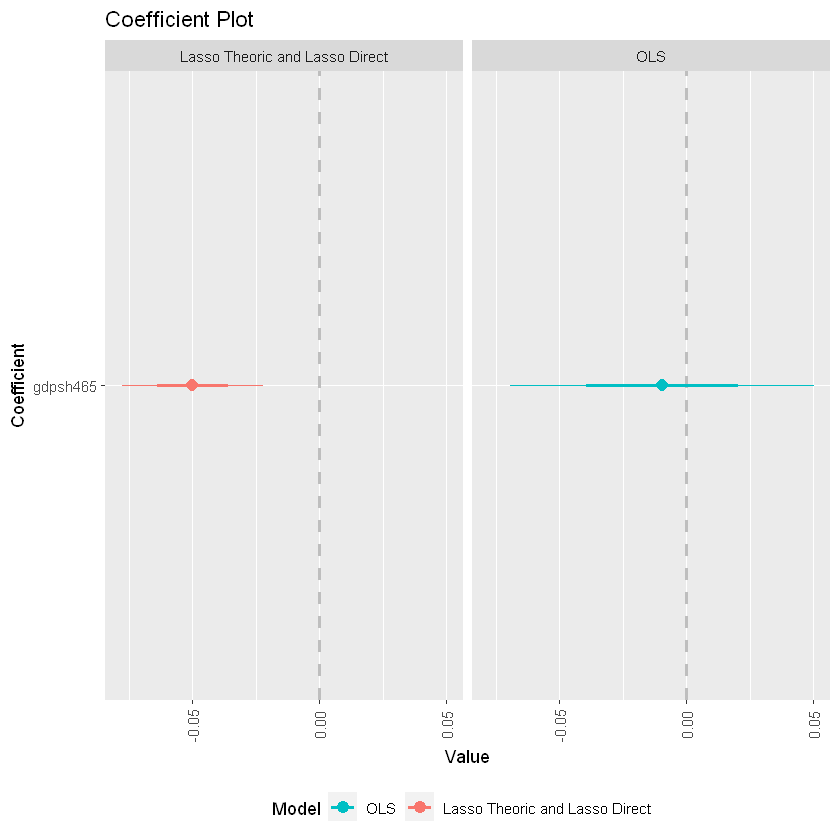

In [185]:
library(coefplot)

coefplot::multiplot(reg_ols,lasso,
    coefficients=c('gdpsh465'), 
    single=FALSE, 
    names=c(reg_ols="OLS",lasso="Lasso Theoric and Lasso Direct"))